# Predicting the Outcome of Starcraft II matches

Importing required libaries

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Business Understanding

## Data Mining

The data used for this project was scraped from http://aligulac.com/. Aligulac has results of Starcraft II matches going back to February 2010. For this project I will be using results from the previous two years, 73k matches.

The code for the web scraping can be found in DataMining.ipynb.

Difficulties faced when web scraping:
- To get a large enough data set multiple webpages would have to be visited.
  - This was solved using selenium to navigate to the next page.
- Some players were missing their country and an alternative empty value was not being recorded affecting the resulting data set.
  - The lengths of the table cells the players country and other information was different depending on whether or not country info was present. Using this it was possible to add an empty value for players without a country listed.
- The other match information, rated/unrated, online/lan, game version. Did not include anything to represent a rated match, only unrated.
  - I assumed all unmarked matches were rated. Again the length of the table cell varied if the unrated symbol was included or not.  

## Data Cleaning

In [84]:
data = pd.read_csv("data.csv")

### Data Types  

- MatchId        |   Numerical Discreet   |   Ignored
- PlayerAName    |   Categorical Nominal  |   Ignored
- PlayerACountry |   Categorical Nominal  |  Explanitory
- PlayerARating  |   Numeric Discreet     |   Explanitory
- PlayerARace    |   Categorical Nominal  |   Explanitory
- PlayerBName    |   Categorical Nominal  |   Ignored
- PlayerBCountry |   Categorical Nominal  |   Explanitory
- PlayerBRating  |   Numeric Discreet     |   Explanitory
- PlayerBRace    |   Categorical Nominal  |  Explanitory
- GameVersion    |   Categorical Nominal  |  Ignored
- isRatedMatch   |   Categorical Nominal  |   Likely Ignored
- isLan          |   Categorical Nominal  |   Explanitory
- MapScore       |   Categorical Nominal  |   Explanitory
- PlayerAWin     |   Numeric Discreet     |   Response

In [85]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73486 entries, 0 to 73485
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MatchId         73486 non-null  int64 
 1   PlayerAName     73486 non-null  object
 2   PlayerACountry  73191 non-null  object
 3   PlayerARating   72028 non-null  object
 4   PlayerARace     73486 non-null  object
 5   PlayerBName     73486 non-null  object
 6   PlayerBCountry  72902 non-null  object
 7   PlayerBRating   71583 non-null  object
 8   PlayerBRace     73486 non-null  object
 9   GameVersion     73486 non-null  object
 10  isRatedMatch    73486 non-null  object
 11  isLan           73486 non-null  object
 12  MapScore        73486 non-null  object
 13  PlayerAWin      73486 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 7.8+ MB
None


### Missing Values

  Due to the size of the dataset, I have decided that removing rows that are missing information, player rating or player nationality, will not have a major impact on the dataset and is a suitable method to deal with missing values.

In [86]:
print(data.isnull().sum())

data = data.drop(data[data.PlayerACountry.isnull()].index)
data = data.drop(data[data.PlayerARating.isnull()].index)
data = data.drop(data[data.PlayerBCountry.isnull()].index)
data = data.drop(data[data.PlayerBRating.isnull()].index)

print(data.isnull().sum())

MatchId              0
PlayerAName          0
PlayerACountry     295
PlayerARating     1458
PlayerARace          0
PlayerBName          0
PlayerBCountry     584
PlayerBRating     1903
PlayerBRace          0
GameVersion          0
isRatedMatch         0
isLan                0
MapScore             0
PlayerAWin           0
dtype: int64
MatchId           0
PlayerAName       0
PlayerACountry    0
PlayerARating     0
PlayerARace       0
PlayerBName       0
PlayerBCountry    0
PlayerBRating     0
PlayerBRace       0
GameVersion       0
isRatedMatch      0
isLan             0
MapScore          0
PlayerAWin        0
dtype: int64


### Converting Data Types

 Some of the numeric data types in the csv file were interpeted as strings. I am converting these back to numeric. 

In [87]:
data["PlayerARating"] = pd.to_numeric(data["PlayerARating"])
data["PlayerBRating"] = pd.to_numeric(data["PlayerBRating"])

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 69476 entries, 0 to 73485
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MatchId         69476 non-null  int64 
 1   PlayerAName     69476 non-null  object
 2   PlayerACountry  69476 non-null  object
 3   PlayerARating   69476 non-null  int64 
 4   PlayerARace     69476 non-null  object
 5   PlayerBName     69476 non-null  object
 6   PlayerBCountry  69476 non-null  object
 7   PlayerBRating   69476 non-null  int64 
 8   PlayerBRace     69476 non-null  object
 9   GameVersion     69476 non-null  object
 10  isRatedMatch    69476 non-null  object
 11  isLan           69476 non-null  object
 12  MapScore        69476 non-null  object
 13  PlayerAWin      69476 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 8.0+ MB
None


### Reducing the number of Countries recorded in the Dataset

In the dataset there are players from 86 different countries. To make analysing the data easier and to improve the performance of the model for players from countries that appear infrequently, I will keep the top 5 countries, South Korea (KR), Russia (RU), Poland (PL), USA (US) and Germany (DE). The rest of the players will be categorised as "Other".

In [88]:
print("Unique Countries: " + str(pd.concat([data["PlayerACountry"], data["PlayerBCountry"]]).nunique()))
print(pd.concat([data["PlayerACountry"], data["PlayerBCountry"]]).value_counts())

Unique Countries: 86
KR    22710
RU    14574
PL    14116
US    10772
DE     9255
      ...  
PK        1
JM        1
TH        1
TT        1
IR        1
Name: count, Length: 86, dtype: int64


In [89]:
data.loc[(data["PlayerACountry"] != "KR") & (data["PlayerACountry"] != "RU") & (data["PlayerACountry"] != "PL") & (data["PlayerACountry"] != "US") & (data["PlayerACountry"] != "DE"), "PlayerACountry"] = "Other"
data.loc[(data["PlayerBCountry"] != "KR") & (data["PlayerBCountry"] != "RU") & (data["PlayerBCountry"] != "PL") & (data["PlayerBCountry"] != "US") & (data["PlayerBCountry"] != "DE"), "PlayerBCountry"] = "Other"
print(pd.concat([data["PlayerACountry"], data["PlayerBCountry"]]).value_counts())

Other    67525
KR       22710
RU       14574
PL       14116
US       10772
DE        9255
Name: count, dtype: int64


### Dropping unnecessary columns

MatchId is unique to every match and therefore can be ignored and dropped.

In [90]:
data.drop("MatchId", axis= 1, inplace= True)

The vast majority of matches are played on the most recent game version LotV. The older game versions WoL and HotS make up a small minority of the matches. I will focus on the current version of the game, removing the matches from past versions and then dropping the column as all matches will be on the same version.

In [91]:
print(data["GameVersion"].value_counts())

GameVersion
LotV    69434
WoL        39
HotS        3
Name: count, dtype: int64


In [92]:
data = data.drop(data[data["GameVersion"] == "WoL"].index)
data = data.drop(data[data["GameVersion"] == "HotS"].index)
print(data["GameVersion"].value_counts())

GameVersion
LotV    69434
Name: count, dtype: int64


In the 69,434 matches there are 2,760 unique players. On average a player will appear in 25 matches. Therefore I will drop the name columns.

In [93]:
print(pd.concat([data["PlayerAName"], data["PlayerBName"]]).nunique())

2760


In [94]:
data.drop("PlayerAName", axis= 1, inplace= True)
data.drop("PlayerBName", axis= 1, inplace= True)

### Outliers

There are no outliers in the Ratings of the players. Therefore all matches will be kept.

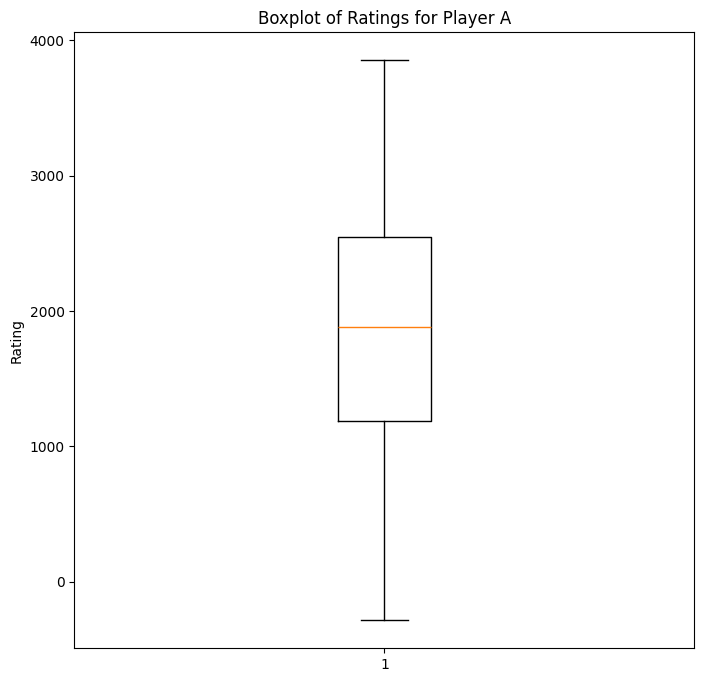

count    69434.000000
mean      1910.808955
std        776.447167
min       -284.000000
25%       1191.000000
50%       1884.000000
75%       2545.000000
max       3852.000000
Name: PlayerARating, dtype: float64


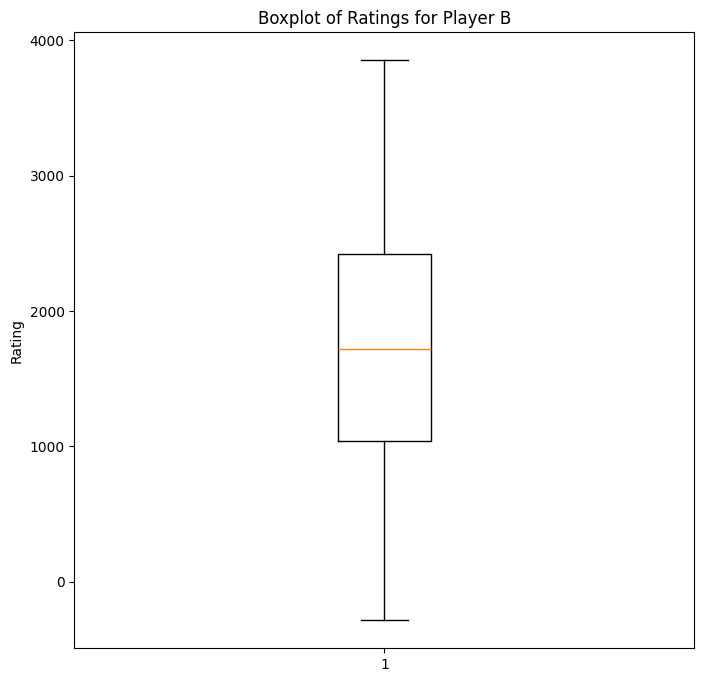

count    69434.000000
mean      1775.241063
std        768.754189
min       -284.000000
25%       1038.000000
50%       1721.000000
75%       2419.000000
max       3852.000000
Name: PlayerBRating, dtype: float64


In [95]:
figure(num=None, figsize=(8, 8), dpi=100, facecolor="w", edgecolor="k")
plt.boxplot(x= data.PlayerARating)
plt.title("Boxplot of Ratings for Player A")
plt.ylabel("Rating")
plt.show()

print(data.PlayerARating.describe())

figure(num=None, figsize=(8, 8), dpi=100, facecolor="w", edgecolor="k")
plt.boxplot(x= data.PlayerBRating)
plt.title("Boxplot of Ratings for Player B")
plt.ylabel("Rating")
plt.show()

print(data.PlayerBRating.describe())

## Data Exploration

### Univariate

#### Categorical

##### Player Nationality

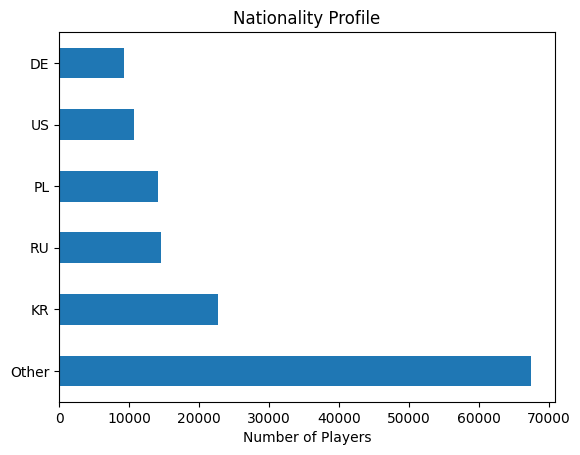

Other    67489
KR       22702
RU       14573
PL       14089
US       10762
DE        9253
Name: count, dtype: int64


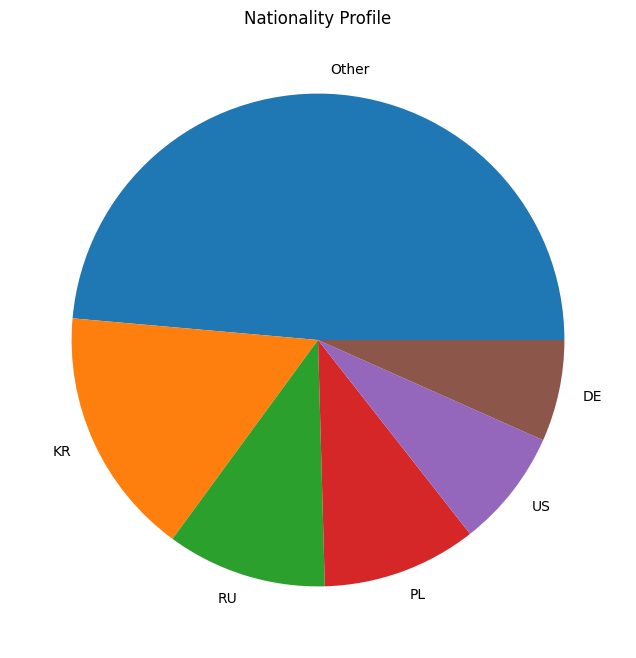

In [106]:
countries = pd.concat([data["PlayerACountry"], data["PlayerBCountry"]]).value_counts()

countries.plot.barh()
plt.title("Nationality Profile")
plt.xlabel("Number of Players")
plt.show()


figure(num= None, figsize=(8, 8), dpi= 100, facecolor="w", edgecolor="k")
countries = pd.concat([data["PlayerACountry"], data["PlayerBCountry"]]).value_counts(normalize= True)
countries.plot.pie()
plt.title("Nationality Profile")
plt.ylabel("")
plt.show()

print(pd.concat([data["PlayerACountry"], data["PlayerBCountry"]]).value_counts())

##### Players ingame race

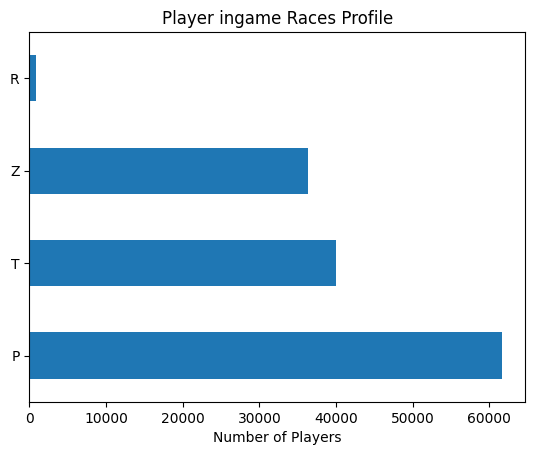

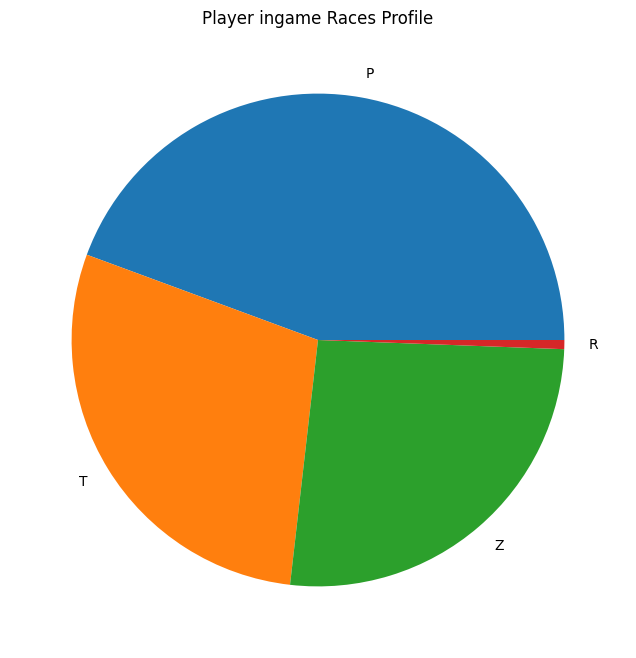

P    61623
T    40013
Z    36407
R      825
Name: count, dtype: int64


In [108]:
races = pd.concat([data["PlayerARace"], data["PlayerBRace"]]).value_counts()

races.plot.barh()
plt.title("Player ingame Races Profile")
plt.xlabel("Number of Players")
plt.show()

figure(num= None, figsize=(8, 8), dpi= 100, facecolor= "w", edgecolor= "k")
races = pd.concat([data["PlayerARace"], data["PlayerBRace"]]).value_counts(normalize= True)
races.plot.pie()
plt.title("Player ingame Races Profile")
plt.ylabel("")
plt.show()

print(pd.concat([data["PlayerARace"], data["PlayerBRace"]]).value_counts())

##### Was the match online or offline (LAN)?

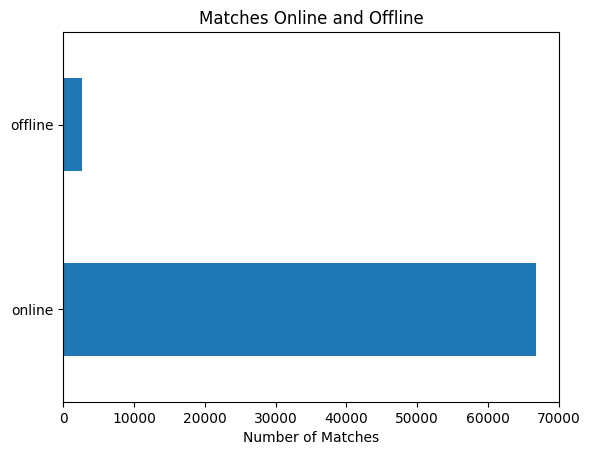

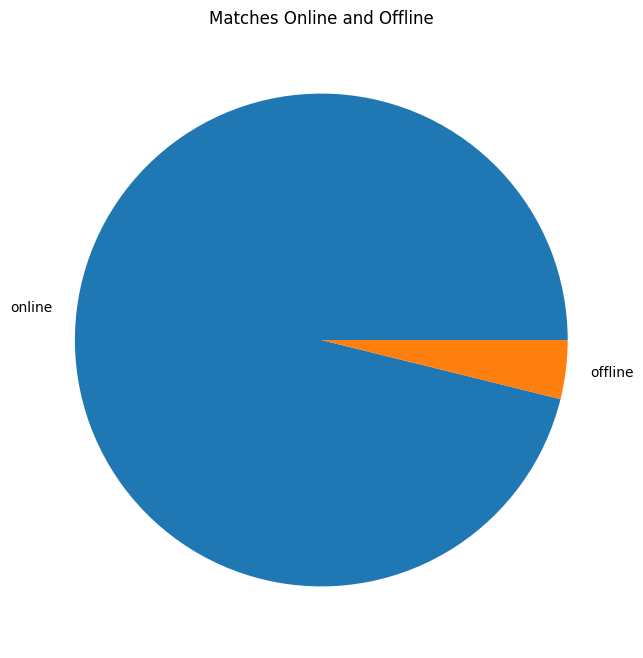

isLan
online     66758
offline     2676
Name: count, dtype: int64


In [112]:
isLan = data["isLan"].value_counts()

isLan.plot.barh()
plt.title("Matches Online and Offline")
plt.xlabel("Number of Matches")
plt.ylabel("")
plt.show()

figure(num= None, figsize=(8, 8), dpi= 100, facecolor= "w", edgecolor= "k")
isLan = data["isLan"].value_counts(normalize= True)
isLan.plot.pie()
plt.title("Matches Online and Offline")
plt.ylabel("")
plt.show()

print(data["isLan"].value_counts())

#### Numerical

##### Player Rating

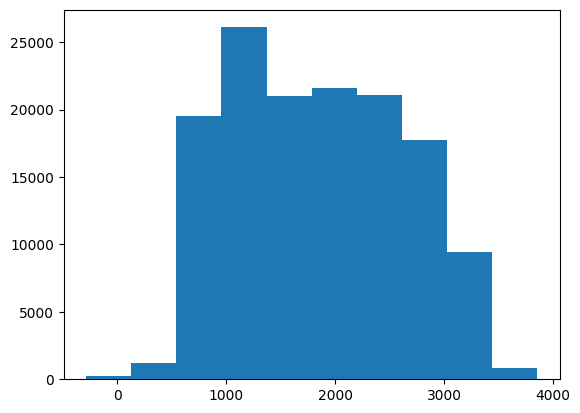

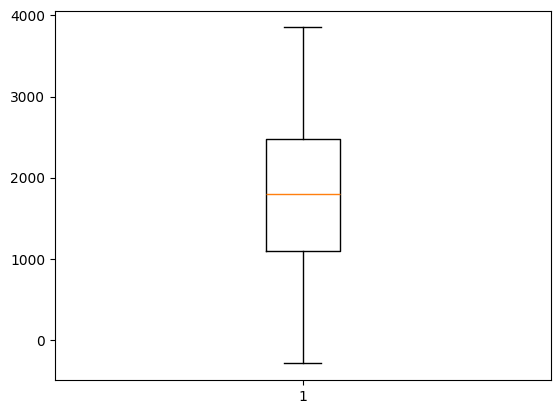

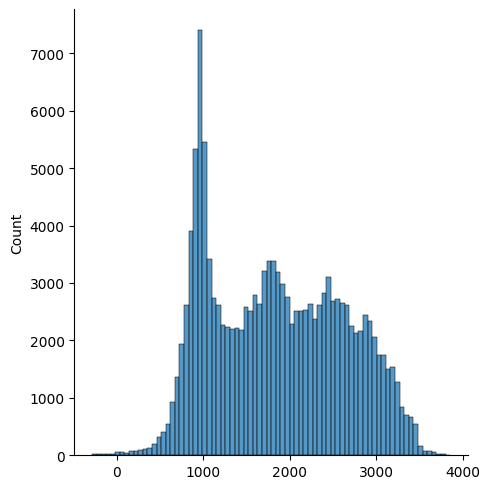

count    138868.000000
mean       1843.025009
std         775.575271
min        -284.000000
25%        1098.000000
50%        1807.000000
75%        2480.000000
max        3852.000000
dtype: float64


In [119]:
plt.hist(pd.concat([data["PlayerARating"], data["PlayerBRating"]]))
plt.show()

plt.boxplot(pd.concat([data["PlayerARating"], data["PlayerBRating"]]))
plt.show()

sns.displot(pd.concat([data["PlayerARating"], data["PlayerBRating"]]))
plt.show()

print(pd.concat([data["PlayerARating"], data["PlayerBRating"]]).describe())

### Bivariate

##### Numeric - Categorical

Rating - Country

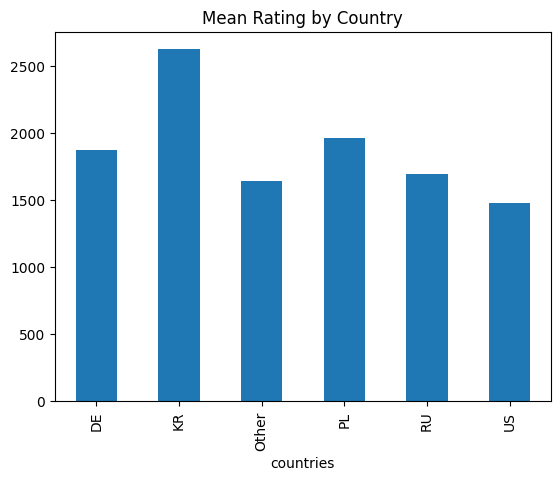

countries
DE       1874.260456
KR       2625.975641
Other    1640.503519
PL       1961.307900
RU       1695.178549
US       1479.940531
Name: ratings, dtype: float64


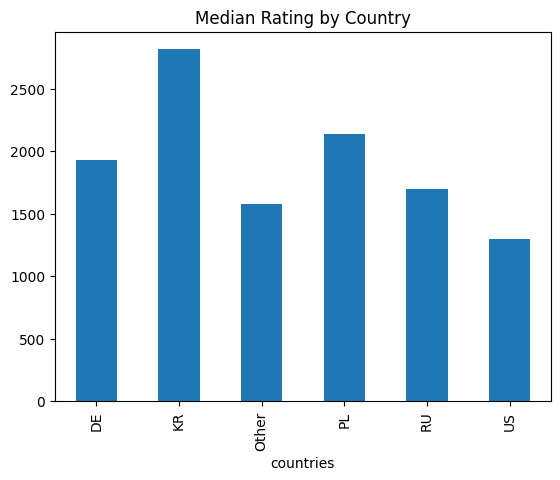

countries
DE       1933.0
KR       2816.0
Other    1582.0
PL       2137.0
RU       1695.0
US       1297.0
Name: ratings, dtype: float64


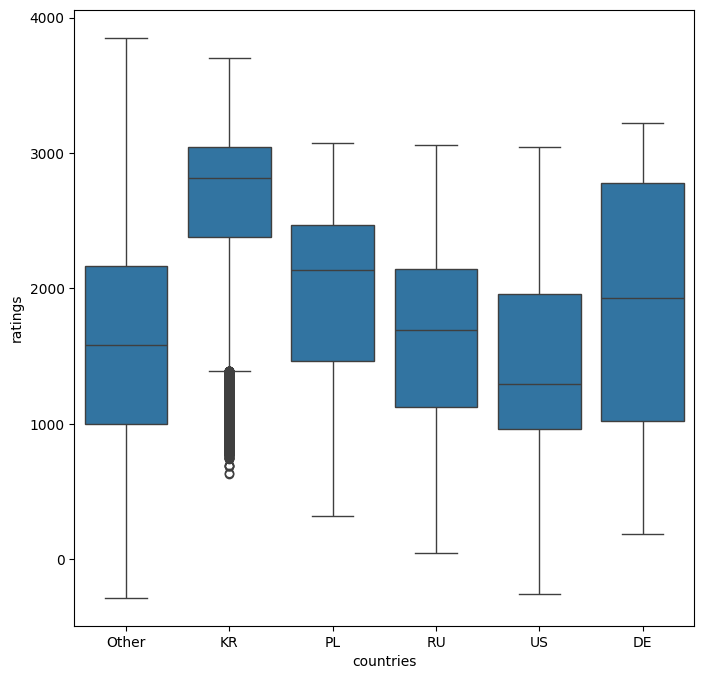

In [131]:
playerCountries = pd.concat([data["PlayerACountry"], data["PlayerBCountry"]])
playerRatings = pd.concat([data["PlayerARating"], data["PlayerBRating"]])
df = pd.DataFrame()
df["countries"] = playerCountries
df["ratings"] = playerRatings

meanRatingByCountry = df.groupby("countries")["ratings"].mean()
meanRatingByCountry.plot.bar()
plt.title("Mean Rating by Country")
plt.show()
print(meanRatingByCountry)

medianRatingByCountry = df.groupby("countries")["ratings"].median()
medianRatingByCountry.plot.bar()
plt.title("Median Rating by Country")
plt.show()
print(medianRatingByCountry)

figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
sns.boxplot(x=df.countries, y= df.ratings)
plt.show()

Rating - Ingame Race

In [ ]:
playerRaces = pd.concat([data["PlayerARace"], data["PlayerBRace"]])
playerRatings = pd.concat([data["PlayerARating"], data["PlayerBRating"]])
df = pd.DataFrame()

## Feature Engineering

## Predictive Modelling

## Findings